<a href="https://colab.research.google.com/github/josetoujours/Predict-The-Price-Of-Books/blob/master/Predict_The_Price_Of_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The so-called paradoxes of an author, to which a reader takes exception, often exist not in the author's book at all, but rather in the reader's head. - Friedrich Nietzsche Books are open doors to the unimagined worlds which is unique to every person. It is more than just a hobby for many. There are many among us who prefer to spend more time with books than anything else. Here we explore a big database of books. Books of different genres, from thousands of authors. In this challenge, participants are required to use the dataset to build a Machine Learning model to predict the price of books based on a given set of features. Size of training set: 6237 records Size of test set: 1560 records FEATURES: Title: The title of the book Author: The author(s) of the book. Edition: The edition of the book eg (Paperback,– Import, 26 Apr 2018) Reviews: The customer reviews about the book Ratings: The customer ratings of the book Synopsis: The synopsis of the book Genre: The genre the book belongs to BookCategory: The department the book is usually available at. Price: The price of the book (Target variable)

# Chargement et inspection de données

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Data_Test.xlsx to Data_Test (1).xlsx
Saving Data_Train.xlsx to Data_Train (2).xlsx
Saving Sample_Submission.xlsx to Sample_Submission (1).xlsx
User uploaded file "Data_Test.xlsx" with length 741522 bytes
User uploaded file "Data_Train.xlsx" with length 2790654 bytes
User uploaded file "Sample_Submission.xlsx" with length 16039 bytes


In [9]:
import pandas as pd
import numpy as np

df= pd.read_excel("Data_Train.xlsx")
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [33]:
#vérification de valeurs manquantes
df.isnull().sum()

Title           0
Author          0
Edition         0
Reviews         0
Ratings         0
Synopsis        0
Genre           0
BookCategory    0
Price           0
dtype: int64

La particularité de ce dataset est qu'il n'y a pas de valeurs manquantes, par contre, il y a beaucoup de chaines de caractères que nous allons traiter dans la 3ème partie.

***2 colonnes semblent particulièrement importantes : Ratings et Reviews.
Nous allons d'emblée les transformer en float.
Cette première approche nous permet de tester une première prévision avec ces 2 paramètres uniquement. 
  

In [10]:
test= pd.read_excel("Data_Test.xlsx")
test['Reviews'] = test.Reviews.apply(lambda r: float(r.split()[0]))
test['Ratings']= test.Ratings.str.extract('(\d+)')
test.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4,960,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0,1,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0,4,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1,11,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media"
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4,9,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing"


In [11]:
df['Reviews'] = df.Reviews.apply(lambda r: float(r.split()[0]))
df['Ratings']= df.Ratings.str.extract('(\d+)')
df["Ratings"] = df.Ratings.astype(float)
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9,14.0,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8,6.0,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1,13.0,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0,1.0,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   float64
 4   Ratings       6237 non-null   float64
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(3), object(6)
memory usage: 438.7+ KB


In [26]:
df.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price'],
      dtype='object')

In [21]:
df.describe()

,Reviews,Ratings,Price
count,6237.000000,6237.000000,6237.000000
mean,4.293202,29.828122,560.707516
std,0.662501,84.139256,690.110657
min,1.000000,1.000000,25.000000
25%,4.000000,2.000000,249.180000
50%,4.400000,6.000000,373.000000
75%,4.800000,21.000000,599.000000
max,5.000000,973.000000,14100.000000


Nous allons tester plusieurs hypothèses de prédictions:

1/On part du principe que seuls comptent "ratings" et "reviews" et on développe des prédictions avec ces 2 paramètres uniquement. ça reste quand même un peu juste

2/ En gardant toutes les colonnes et en transformant uniquement "ratings et reviews" en float. Le problème c'est que peu d'algorithmes acceptent les chaines de caractères

3/ On retravaille les colonnes "editions et genre"

4/ Ensuite, on compare les MSE pour chacune des 3 prédictions

In [22]:
!pip install pycaret

     |████████████████████████████████| 256kB 3.0MB/s 
     |████████████████████████████████| 13.9MB 301kB/s 
     |████████████████████████████████| 266kB 49.9MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 66.1MB 99kB/s 
     |████████████████████████████████| 1.6MB 43.5MB/s 
     |████████████████████████████████| 6.8MB 46.0MB/s 
     |████████████████████████████████| 1.8MB 45.5MB/s 
     |████████████████████████████████| 266kB 47.8MB/s 
     |████████████████████████████████| 174kB 49.8MB/s 
     |████████████████████████████████| 327kB 47.1MB/s 
     |████████████████████████████████| 153kB 48.9MB/s 
     |████████████████████████████████| 1.1MB 38.5MB/s 
     |████████████████████████████████| 163kB 45.5MB/s 
     |████████████████████████████████| 6.0MB 23.3MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 2.1MB 38.3MB/s

# Prédictions N°1 : Uniquement 2 paramètres, tansformés en float : Ratings et Reviews; les autres colonnes ayant ét ignorés

				
Model	= 	Light Gradient Boosting Machine	
MAE	= 346.4663	
MSE= 415443.5673	
RMSE= 644.5491	
R2= 0.0363	
RMSLE= 0.7949	
MAPE= 0.9702

In [27]:
df_1= pd.DataFrame(df, columns=['Reviews', 'Ratings','Price'])
df_1.head()

,Reviews,Ratings,Price
0,4.0,8.0,220.00
1,3.9,14.0,202.93
2,4.8,6.0,299.00
3,4.1,13.0,180.00
4,5.0,1.0,965.62


In [28]:
from pycaret.regression import *
PTA= setup(df_1, 
           target= "Price")

 
Setup Succesfully Completed.


,Description,Value
0,session_id,6428
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(6237, 3)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [29]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,357.8551,481002.2121,674.9867,0.0307,0.8057,0.9826,0.0659
1,Least Angle Regression,363.4902,486531.2894,678.6628,0.0206,0.8279,1.0263,0.0058
2,Linear Regression,363.4902,486531.2894,678.6628,0.0206,0.8279,1.0263,0.0044
3,Ridge Regression,363.4899,486531.0855,678.6629,0.0205,0.8279,1.0264,0.0046
4,Lasso Regression,363.4811,486532.2414,678.6711,0.0205,0.8278,1.0268,0.0050
5,Elastic Net,364.8061,487833.4072,679.8443,0.0164,0.8297,1.0409,0.0051
6,Random Sample Consensus,339.8586,491435.5836,681.8348,0.0121,0.8021,0.8727,0.0902
7,Orthogonal Matching Pursuit,367.1064,490742.7946,681.9520,0.0102,0.8302,1.0457,0.0046
8,Bayesian Ridge,367.9364,491420.7230,682.7166,0.0071,0.8368,1.0576,0.0055
9,Lasso Least Angle Regression,370.1026,494199.5855,684.8543,0.0004,0.8356,1.0695,0.0050


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=6428, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
LGBMR = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,371.2810,479769.9451,692.6543,0.0086,0.8313,1.0288
1,312.3490,220015.0404,469.0576,0.0788,0.7721,0.9927
2,330.3572,317401.1301,563.3836,-0.0272,0.7926,0.9971
3,368.5624,492220.7165,701.5844,0.0273,0.7776,0.8604
4,411.1837,1169004.8108,1081.2053,0.0182,0.8348,1.0329
5,372.5804,616515.8087,785.1852,0.0180,0.8429,1.0640
6,338.9780,372755.4351,610.5370,0.0603,0.8024,0.9800
7,382.5067,456659.2952,675.7657,0.0123,0.8158,0.9266
8,337.9191,321705.1055,567.1905,0.0662,0.7766,0.9189
9,352.8332,363974.8335,603.3033,0.0443,0.8114,1.0244


In [31]:
predict_model(LGBMR)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,346.4663,415443.5673,644.5491,0.0363,0.7949,0.9702


,Reviews,Ratings,Price,Label
0,1.0,1.0,1490.0,757.0421
1,4.8,8.0,736.0,585.2178
2,4.7,27.0,399.0,399.4185
3,4.5,12.0,299.0,734.0016
4,4.6,6.0,180.0,671.0663
...,...,...,...,...
1867,5.0,3.0,413.0,806.9494
1868,4.2,26.0,179.0,425.3128
1869,4.2,30.0,671.0,340.8204
1870,3.9,12.0,205.0,454.3258


In [34]:
test_predictions= predict_model(LGBMR, data= test)
test_predictions.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Label
index,,,,,,,,,
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4,960,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery",187.3903
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0,1,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media",780.9650
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0,4,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance,960.8569
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1,11,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media",572.7686
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4,9,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing",481.1592


In [ ]:
sub= pd.read_excel('/content/Sample_Submission.xlsx')
output= pd.DataFrame({'ID': sub.index,
                     "Label": test_predictions.Label})
output.to_csv('submission_price_books.csv', index= False)

# Prédictions N°2 : Toutes les colonnes sont utilisées, ratings et reviews sont en float

Model= Light Gradient Boosting Machine	
MAE= 347.7959	
MSE= 416420.377	
RMSE= 645.3064	
R2= 0.034	
RMSLE	= 0.7943	
MAPE= 0.974


In [23]:
from pycaret.regression import *
PTA= setup(df, 
           target= "Price")

 
Setup Succesfully Completed.


,Description,Value
0,session_id,7830
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(6237, 9)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,6
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [35]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,357.8551,481002.2121,674.9867,0.0307,0.8057,0.9826,0.0668
1,Least Angle Regression,363.4902,486531.2894,678.6628,0.0206,0.8279,1.0263,0.0051
2,Linear Regression,363.4902,486531.2894,678.6628,0.0206,0.8279,1.0263,0.0046
3,Ridge Regression,363.4899,486531.0855,678.6629,0.0205,0.8279,1.0264,0.0047
4,Lasso Regression,363.4811,486532.2414,678.6711,0.0205,0.8278,1.0268,0.0049
5,Elastic Net,364.8061,487833.4072,679.8443,0.0164,0.8297,1.0409,0.0048
6,Random Sample Consensus,339.8586,491435.5836,681.8348,0.0121,0.8021,0.8727,0.0927
7,Orthogonal Matching Pursuit,367.1064,490742.7946,681.9520,0.0102,0.8302,1.0457,0.0043
8,Bayesian Ridge,367.9364,491420.7230,682.7166,0.0071,0.8368,1.0576,0.0045
9,Lasso Least Angle Regression,370.1026,494199.5855,684.8543,0.0004,0.8356,1.0695,0.0052


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=6428, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
LGBMR = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,371.2810,479769.9451,692.6543,0.0086,0.8313,1.0288
1,312.3490,220015.0404,469.0576,0.0788,0.7721,0.9927
2,330.3572,317401.1301,563.3836,-0.0272,0.7926,0.9971
3,368.5624,492220.7165,701.5844,0.0273,0.7776,0.8604
4,411.1837,1169004.8108,1081.2053,0.0182,0.8348,1.0329
5,372.5804,616515.8087,785.1852,0.0180,0.8429,1.0640
6,338.9780,372755.4351,610.5370,0.0603,0.8024,0.9800
7,382.5067,456659.2952,675.7657,0.0123,0.8158,0.9266
8,337.9191,321705.1055,567.1905,0.0662,0.7766,0.9189
9,352.8332,363974.8335,603.3033,0.0443,0.8114,1.0244


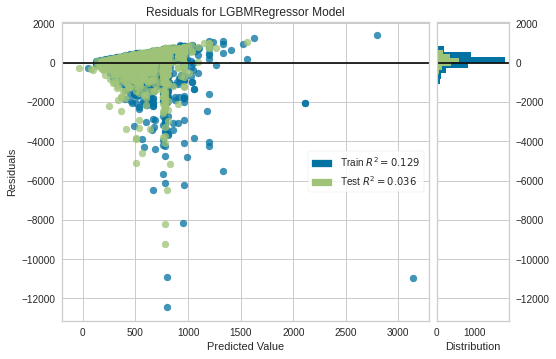

In [37]:
plot_model(LGBMR)

In [38]:
predict_model(LGBMR)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,346.4663,415443.5673,644.5491,0.0363,0.7949,0.9702


,Reviews,Ratings,Price,Label
0,1.0,1.0,1490.0,757.0421
1,4.8,8.0,736.0,585.2178
2,4.7,27.0,399.0,399.4185
3,4.5,12.0,299.0,734.0016
4,4.6,6.0,180.0,671.0663
...,...,...,...,...
1867,5.0,3.0,413.0,806.9494
1868,4.2,26.0,179.0,425.3128
1869,4.2,30.0,671.0,340.8204
1870,3.9,12.0,205.0,454.3258


In [39]:
tuned_lgbmr= tune_model(LGBMR)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,371.1531,482339.6594,694.5068,0.0033,0.8304,1.0279
1,312.3610,220038.5750,469.0827,0.0787,0.7715,0.9903
2,329.4344,319176.8709,564.9574,-0.0329,0.7928,0.9920
3,369.3078,493575.0965,702.5490,0.0246,0.7786,0.8586
4,410.4987,1168914.3789,1081.1634,0.0183,0.8350,1.0300
5,373.7000,617366.2852,785.7266,0.0166,0.8460,1.0718
6,339.5379,373679.5532,611.2933,0.0580,0.8096,0.9837
7,384.1222,458597.9377,677.1986,0.0081,0.8186,0.9326
8,336.9157,320565.6283,566.1852,0.0695,0.7740,0.9145
9,353.3315,365333.1621,604.4280,0.0408,0.8165,1.0258


In [40]:
predict_model(tuned_lgbmr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,347.7959,416420.377,645.3064,0.034,0.7943,0.974


,Reviews,Ratings,Price,Label
0,1.0,1.0,1490.0,755.5978
1,4.8,8.0,736.0,579.7682
2,4.7,27.0,399.0,430.2214
3,4.5,12.0,299.0,709.2554
4,4.6,6.0,180.0,681.9841
...,...,...,...,...
1867,5.0,3.0,413.0,808.4802
1868,4.2,26.0,179.0,428.2542
1869,4.2,30.0,671.0,342.5086
1870,3.9,12.0,205.0,465.3519


# Prédictions N°3 : 
Il s'agit d'envisager la pertinence de chaque colonne: 

*soit la colonne est supprimée, 

*soit elle est encodée. 

*L'objectif étant qu'il n'y ait plus d'éléments de type "objet" dans le dataset

On supprime titre et synopsis, en présupposant qu'ils ne sont pertinents pour nos prévisions.

On vérifie le nombre d'auteurs présents dans le dataset et leur récurrence ; ensuite, on encode les valeurs de cette colonne 

# Validation des prédictions

In [ ]:
final_lgbmr= finalize_model(tuned_lgbmr)